# Set-up

In [1]:
import jax
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.pyplot as plt
import surrojax_gp
import os
import sys
sys.path.insert(0, '..')
import plotting_helpers

Create directory to save figures:

In [2]:
fig_save_dir = './figs'
if not os.path.isdir(fig_save_dir):
    os.mkdir(fig_save_dir)

Plotting function:

In [3]:
def plot_surface(x, y, z, z_lims=None, num_x_ticks=10, num_y_ticks=10, 
                 num_z_ticks=10, z_ticks_dp=1, train_pts=None, z_label=None):
    if z_label is None:
        z_label = '$z$'
    fig, ax = plt.subplots()
    if z_lims is None:
        z_lims = (jnp.min(z), jnp.max(z))
    im = plt.imshow(z, cmap='coolwarm', origin='lower', vmin=z_lims[0], vmax=z_lims[1])
    plotting_helpers.set_x_and_y_ticks(ax, x, y, num_x_ticks, num_y_ticks)
    plotting_helpers.create_colourbar(im, z_label, z_lims, num_z_ticks, z_ticks_dp)
    if train_pts is not None:
        plot_pts = {}
        for i in (0, 1):
            plot_pts[i] = x.shape[i]*(train_pts[i] - jnp.min(train_pts[i]))/(jnp.max(train_pts[i]) - jnp.min(train_pts[i]))
        plt.plot(plot_pts[0].squeeze(), plot_pts[1].squeeze(), 'x', color='black', markersize=5)
        ax.set_xlim(jnp.min(plot_pts[0]), jnp.max(plot_pts[0]))
        ax.set_ylim(jnp.min(plot_pts[1]), jnp.max(plot_pts[1]))
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    plotting_helpers.clean_up_plot(fig)

Function to differentiate and vmap:

In [4]:
def grad_and_vmap(func, args):
    grad = func
    for arg in args:
        grad = jax.jacfwd(grad, argnums=arg)
    for _ in range(2):
        grad = jax.vmap(grad, in_axes=(0,0))
    return grad    

# Verification

Function to learn:

In [5]:
# Peak function (see: https://mathworks.com/help/matlab/ref/peaks.html)
def peaks(x, y):
    first_term = 3*(1-x)**2*jnp.exp(-x**2-(y+1)**2)
    second_term = -10*(x/5 - x**3 - y**5)*jnp.exp(-x**2-y**2)
    third_term = -1/3*jnp.exp(-(x+1)**2-y**2)
    return first_term + second_term + third_term

Kernel:

In [6]:
def kernel(x_1, x_2, params):
    lengths = jnp.array([params[f"length_{i}"] for i in range(2)])
    inv_lengths = jnp.diag(lengths**(-1))
    ln_k_d = -0.5*(x_1 - x_2).T @ inv_lengths @ (x_1 - x_2) 
    return params["const"]*jnp.exp(ln_k_d)

Define training data points

In [7]:
num_train_pts = 10
x_vals = jnp.linspace(-3, 3, num_train_pts)
y_vals = jnp.linspace(-3, 3, num_train_pts)
x_train, y_train = jnp.meshgrid(x_vals, y_vals)

Plot 'true' function:

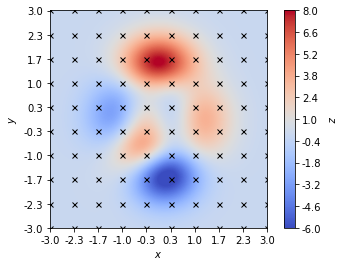

In [8]:
num_pts = 1000
x_vals = jnp.linspace(-3, 3, num_pts)
y_vals = jnp.linspace(-3, 3, num_pts)
x, y = jnp.meshgrid(x_vals, y_vals)
z = peaks(x,y)
plot_surface(x, y, z, z_lims=(-6,8), train_pts=[x_train,y_train])
plt.savefig(os.path.join(fig_save_dir, 'original_peaks.pdf'), bbox_inches='tight')

Create 'training' data:

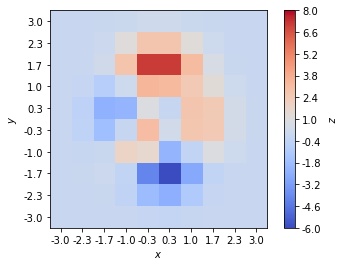

In [9]:
z_train = peaks(x_train,y_train)
plot_surface(x_train, y_train, z_train, z_lims=(-6,8))
plt.savefig(os.path.join(fig_save_dir, 'training_peaks.pdf'), bbox_inches='tight')

Train GP:

In [10]:
constraints = {"length_0": {">": 0.01, "<": 10}, 
               "length_1": {">": 0.01, "<": 10}, 
               "const": {">": 0.01, "<": 10}}
train_features = jnp.stack([x_train.flatten(), y_train.flatten()], axis=1)
train_labels = z_train.flatten()
gp = surrojax_gp.create_gp(kernel, train_features, train_labels, constraints)

3104201.8
1650367.0
1401293.1
1272433.1
627844.94
222.28546
222.285
222.28311
222.2756
222.24557
222.1253
221.64182
219.67023
211.19388
15123.978
201.75723
210.62274
197.98828
15123.977
200.04166
197.69481
197.69167
197.69144
197.69144
197.69144
197.69144
197.69142
197.69142
197.69144
197.69142
197.69142
197.69144
197.69142
197.69142
197.69147
197.69142
197.69142
197.69144
197.69142
197.69142
197.69144
197.69142
197.69142
197.69144
197.69144
197.69144
197.69144
197.69144
197.69144
197.69144
197.69144
197.69144
197.69144
197.69144
197.69144
197.69144
197.69144
197.69144
197.69144
197.69144
      fun: 197.69143676757812
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.12533569e-03, -3.40893312e-05, -2.93333978e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 60
      nit: 8
     njev: 60
   status: 0
  success: True
        x: array([3.05268258, 0.01000188, 0.01000914])
959024.75
222.28546
222.28525
222.28445
222.28125
222.26837
22

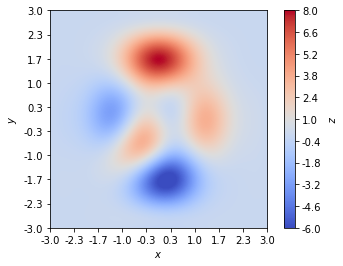

In [11]:
features = jnp.stack([x.flatten(), y.flatten()], axis=1)
gp_vals = gp.predict(features)['mean'].reshape(num_pts,num_pts)
plot_surface(x, y, gp_vals, z_lims=(-6,8))
plt.savefig(os.path.join(fig_save_dir, 'pred_peaks.pdf'), bbox_inches='tight')

# Gradient Predictions

In [12]:
features = jnp.stack([x.flatten(), y.flatten()], axis=1)

Gradient wrt x:

In [13]:
gp_dx = gp.predict(features, grad=({'idx':[0], 'order':1},))['mean'].reshape(num_pts,num_pts)
true_dx = grad_and_vmap(peaks, args=(0,))(x,y).reshape(num_pts,num_pts)

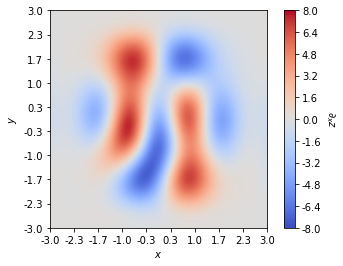

In [14]:
plot_surface(x, y, gp_dx, z_lims=(-8,8), z_label='$\partial_x z$')
plt.savefig(os.path.join(fig_save_dir, 'pred_peaks_dx.pdf'), bbox_inches='tight')

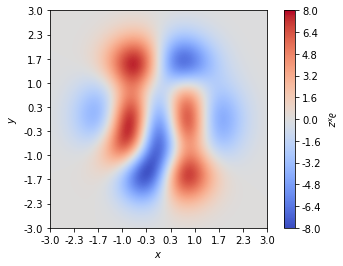

In [15]:
plot_surface(x, y, true_dx, z_lims=(-8,8), z_label='$\partial_x z$')
plt.savefig(os.path.join(fig_save_dir, 'true_peaks_dx.pdf'), bbox_inches='tight')

Gradient wrt y:

In [16]:
gp_dy = gp.predict(features, grad=({'idx':[1], 'order':1},))['mean'].reshape(num_pts,num_pts)
true_dy = grad_and_vmap(peaks, args=(1,))(x,y).reshape(num_pts,num_pts)

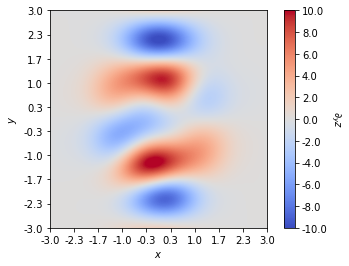

In [17]:
plot_surface(x, y, gp_dy, z_lims=(-10,10), z_label='$\partial_y z$')
plt.savefig(os.path.join(fig_save_dir, 'pred_peaks_dy.pdf'), bbox_inches='tight')

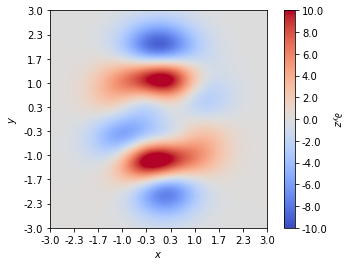

In [18]:
plot_surface(x, y, true_dy, z_lims=(-10,10), z_label='$\partial_y z$')
plt.savefig(os.path.join(fig_save_dir, 'true_peaks_dy.pdf'), bbox_inches='tight')

Mixed gradient wrt x and y:

In [19]:
gp_dxdy = gp.predict(features, grad=({'idx':[0], 'order':1},{'idx':[1], 'order':1}))['mean'].reshape(num_pts,num_pts)
true_dxdy = grad_and_vmap(peaks, args=(0,1))(x,y).reshape(num_pts,num_pts)

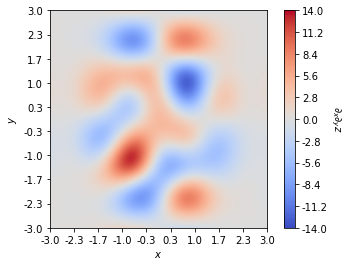

In [20]:
plot_surface(x, y, gp_dxdy, z_lims=(-14,14), z_label='$\partial_x \partial_y z$')
plt.savefig(os.path.join(fig_save_dir, 'pred_peaks_dxdy.pdf'), bbox_inches='tight')

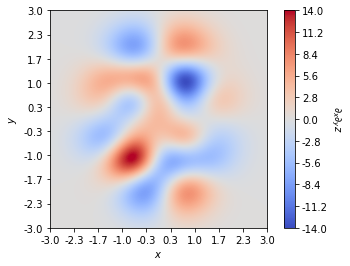

In [21]:
plot_surface(x, y, true_dxdy, z_lims=(-14,14), z_label='$\partial_x \partial_y z$')
plt.savefig(os.path.join(fig_save_dir, 'true_peaks_dxdy.pdf'), bbox_inches='tight')

Double gradient wrt x:

In [22]:
gp_dxdx = gp.predict(features, grad=({'idx':[0], 'order':1},{'idx':[0], 'order':1}))['mean'].reshape(num_pts,num_pts)
true_dxdx = grad_and_vmap(peaks, args=(0,0))(x,y).reshape(num_pts,num_pts)

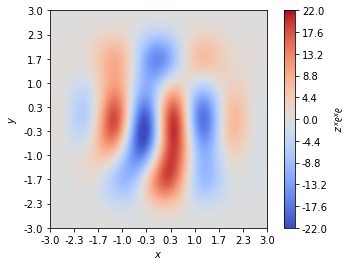

In [23]:
plot_surface(x, y, gp_dxdx, z_lims=(-22,22), z_label='$\partial_x \partial_x z$')
plt.savefig(os.path.join(fig_save_dir, 'pred_peaks_dxdx.pdf'), bbox_inches='tight')

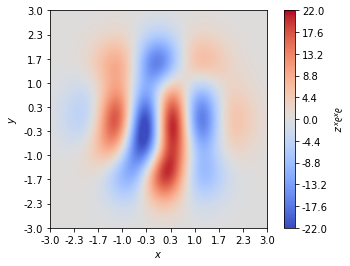

In [24]:
plot_surface(x, y, true_dxdx, z_lims=(-22,22), z_label='$\partial_x \partial_x z$')
plt.savefig(os.path.join(fig_save_dir, 'true_peaks_dxdx.pdf'), bbox_inches='tight')